# Projeto Integrado T10 - Análise de sucesso de jogos de videogame

## Objetivo

Para todo negócio prosperar e continuar evoluindo, é essencial que seja avaliado o histórico de vendas, pois nele é possível entender os principais gostos dos clientes, nichos, produtos populares, entre outros.

Digamos então que a empresa Ice - empresa hipotética para a qual trabalho - deseja determinar e entender o sucesso de um jogo, de forma a investir precisamente em campanhas publicitárias para novos jogos a serem lançados no(s) próximo(s) ano(s). Os dados disponibilizados são de 2016, portanto será feita uma análise tendo em vista projeções para o ano de 2017.

Portanto, vamos iniciar as análises e tentar entender a tendência para jogos de acordo com os últimos anos.

## Importação das bibliotecas

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
from scipy.stats import levene
from datetime import datetime

## Preparação dos dados

In [2]:
# Leitura da base de dados

games = pd.read_csv('datasets/games.csv')

In [3]:
# Visualização de inforamçaões iniciais e de algumas linhas

games.info()
print('Quantidade de linhas duplicadas:', games.duplicated().sum())
games.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
Quantidade de linhas duplicadas: 0


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


A partir das primeiras observações simples, é possível concluir que:

- Não há linhas duplicadas; 
- Somente as colunas **Name**, **Year_of_Release**, **Genre**, **Critic_Score**, **User_Score** e **Rating** possuem valores nulos. No caso das duas primeiras, como são informações de extrema importância, não é desejável ter valores nulos nos dados, portanto as linhas correspondentes serão excluídas. Para o caso das colunas de score, serão excluídas as linhas em que não há valor para nenhuma das três, já que o objetivo é justamente entender o jogos que fizeram sucesso, e sem a informação de score, não é possível determinar o nível de sucesso do jogo; para a última coluna, os valores nulos serão substituídos por 'NR' (No Rating); para a coluna **Genre** serão trocados por 'NG'(No Genre);
- As colunas estão todas com maiúsculos no começo de cada nova palavra, além de não apresentar um padrão de como isso acontece para alguns casos, então, para fins de padronização, todas as colunas terão seus nomes convertidos para minúsculo;
- A colunas **Year_of_Release** apresenta os anos como números decimais, por conta da presença de valores ausentes, portanto, após a exclusão dos valores ausentes, será transformada em tipo inteiro para fins de coerência;
- A coluna **User_Score** não só apresenta os scores numa escala de 0 a 10, assim como está como tipo string, enquanto a coluna **Critic_Score** apresenta-os numa escala de 0 a 100, portanto, para padronizar, a coluna **User_Score** será transformada para ter dados do tipo float e refletir uma escala de 0 a 100, porém há de se considerar as linhas com valores igual a 'tbd', que significa 'to be determined'. Para esses casos, serão trocados por nulo, já que é um valor que significa que não há classificação;
- No caso das colunas **User_Score** e **Critic_Score**, como a quantidade de dados nulos é muito grande, os dados nulos serão mantidos como estão, já que as análises em cima dessas colunas não evolverá os valores nulos, porém os dados das linhas com estes valores nulos são importantes para outras análises;
- A fim de se armazenar informaçãoes sobre o total de vendas, independente da região, será criada uma coluna chamada **total_sales** para representar essa informação;

In [4]:
# Ajuste nos nomes das colunas

games.columns = [column.lower() for column in games.columns]
games.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

In [5]:
# Ajuste nos valores da coluna user_score iguais a tbd com valore nulo

games['user_score'] = games['user_score'].replace('tbd', np.nan)
games['user_score'] = np.where(games['user_score'].notnull(),
                               games['user_score'].astype(float) * 10,
                               games['user_score']
                               )
games['user_score'] = games['user_score'].astype(float)
games['user_score'].head()

0    80.0
1     NaN
2    83.0
3    80.0
4     NaN
Name: user_score, dtype: float64

In [6]:
# Eliminação das linhas com valores nulos para name e year_of_release

games = games[(games['name'].notnull()) & (games['year_of_release'].notnull())]

# conversão da coluna year_of_release para inteiro

games['year_of_release'] = games['year_of_release'].astype(int)

games.info()
games.head()

<class 'pandas.core.frame.DataFrame'>
Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int32  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           9768 non-null   object 
dtypes: float64(6), int32(1), object(4)
memory usage: 1.4+ MB


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,80.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,83.0,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,80.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [7]:
# Preenchimento dos valores nulos para a coluna rating

games['rating'] = games['rating'].fillna('NR')
games.info()
games.head()

<class 'pandas.core.frame.DataFrame'>
Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int32  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           16444 non-null  object 
dtypes: float64(6), int32(1), object(4)
memory usage: 1.4+ MB


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,80.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NR
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,83.0,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,80.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NR


Como não há mais valores nulos nos dados, a coluna **genre** não passará pelo processo de substuição, visto que não foi necessário.

In [8]:
# Geração da coluna total_sales

games['total_sales'] = games['na_sales'] + \
    games['eu_sales'] + games['jp_sales'] + games['other_sales']
games.info()
games.head()

<class 'pandas.core.frame.DataFrame'>
Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int32  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           16444 non-null  object 
 11  total_sales      16444 non-null  float64
dtypes: float64(7), int32(1), object(4)
memory usage: 1.6+ MB


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,80.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NR,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,83.0,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,80.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NR,31.38


Com os dados preparados, hora de começar as análises

## Análise dos dados

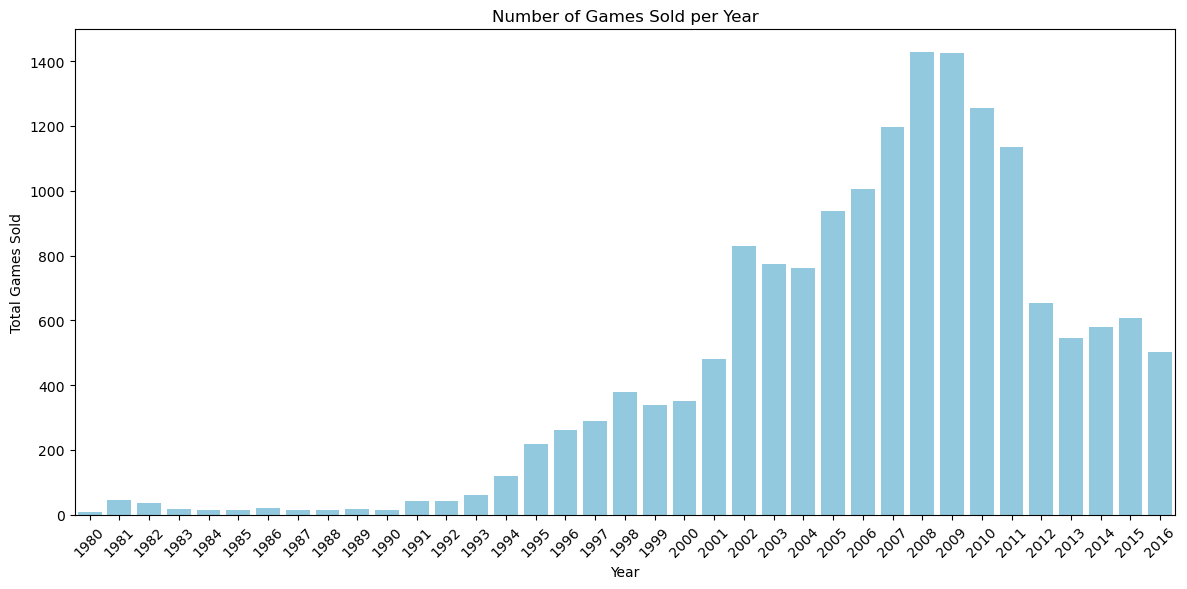

In [9]:
# Checagem da quantidade de jogos vendida por ano

##Código para utilizar a biblioteca Plotly
# games_per_year = games.groupby('year_of_release')['name'].count().reset_index()
# games_per_year.rename(columns={'name': 'total_games_sold'}, inplace=True)

# # Visualização em um gráfico de barras

# fig = px.bar(games_per_year,
#              x='year_of_release',
#              y='total_games_sold',
#              labels={
#                  "year_of_release": "Year",
#                  "total_games_sold": "Total Games Sold",
#              },
#              title='Number of Games Sold per Year')

# fig.show()

##Código para utlizar a bilioteca seaborn

games_per_year = games.groupby('year_of_release')['name'].count().reset_index()
games_per_year.rename(columns={'name': 'total_games_sold'}, inplace=True)

# Visualização em um gráfico de barras com Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=games_per_year, x='year_of_release', y='total_games_sold', color='skyblue')

plt.title('Number of Games Sold per Year')
plt.xlabel('Year')
plt.ylabel('Total Games Sold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Do gráfico acima é possível perceber uma grande popularização dos jogos a partir da década de 90, principalmente a partir de 1995, com uma quantidade de jogos vendidos muito pequena antes deste período, assim como um pico por volta de 2008-2009, e então com uma queda nos últimos anos.

É muito importante também entender como se comporta as vendas por plataforma ao decorrer dos anos, para entender quão rápido se tornaram populares, se ainda mantêm esse status, se alguma ja deixou de vender jogos e etc.
Portanto, para entender melhor o comportamento, vamos dar uma olhada nos dados de venda por plataforma e, para as plataformas mais populares, entender como essas vendas se distribuem de acordo com os anos.

In [10]:
# Gerando informação sobre total de vendas por plataforma por ano

sales_per_plaftorm_per_year = games.groupby(['year_of_release', 'platform'])[
    'total_sales'].sum().reset_index()
sales_per_plaftorm_per_year = sales_per_plaftorm_per_year.reset_index(
    drop=True)
sales_per_plaftorm_per_year

,year_of_release,platform,total_sales
0,1980,2600,11.38
1,1981,2600,35.68
2,1982,2600,28.88
3,1983,2600,5.84
4,1983,NES,10.96
...,...,...,...
233,2016,PSV,4.25
234,2016,Wii,0.18
235,2016,WiiU,4.60
236,2016,X360,1.52


In [11]:
# Geração da informação sobre o total de vendas por plataforma

sales_per_platform = games.groupby(['platform'])['total_sales'].sum().reset_index().sort_values(by='total_sales',
                                                                                                ascending=False)
sales_per_platform = sales_per_platform.reset_index(drop=True)
sales_per_platform

,platform,total_sales
0,PS2,1233.56
1,X360,961.24
2,PS3,931.34
3,Wii,891.18
4,DS,802.78
5,PS,727.58
6,PS4,314.14
7,GBA,312.88
8,PSP,289.53
9,3DS,257.81


Uma primeira olhada nos dados e percebemos várias plataformas muito  populares, como **PS2**, **DS**, **PS4**, entre outras. Para entender a distribuição de vendas ao longo dos anos das plataformas mais populares, vamos trabalhar com as 5 mais populares em vendas.

In [12]:
# Definição das 5 mais populares

top_5_sales = sales_per_platform.nlargest(5, 'total_sales')
top_5_sales

,platform,total_sales
0,PS2,1233.56
1,X360,961.24
2,PS3,931.34
3,Wii,891.18
4,DS,802.78


<Figure size 1200x600 with 0 Axes>

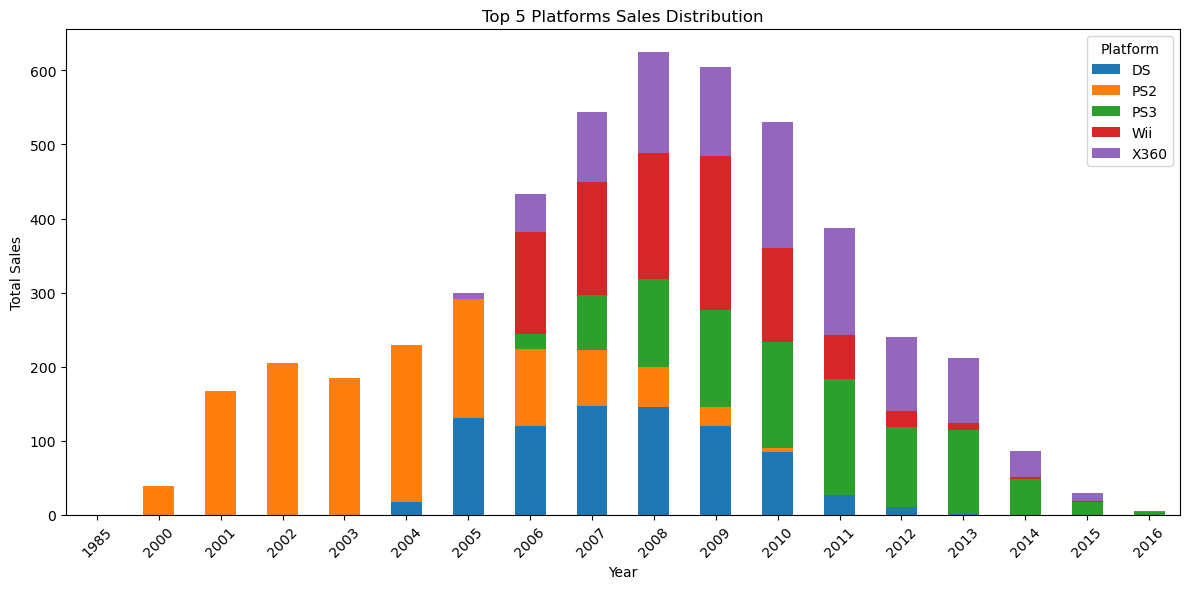

In [ ]:
# Visualizando a distribuição das vendas por ano para cada plataforma

top_5_sales_per_year = sales_per_plaftorm_per_year[sales_per_plaftorm_per_year['platform'].isin(
    top_5_sales['platform'].values)]

##Código para utilizar a biblioteca Plotly
# fig = px.bar(top_5_sales_per_year,
#              x='year_of_release',
#              y='total_sales',
#              labels={
#                  'year_of_release': 'Year',
#                  'total_sales': 'Total Sales'
#              },
#              title='Top 5 Platforms Sales Distribution ',
#              color='platform')

# fig.show()

##Código para utilizar a biblioteca Matplotlib

plt.figure(figsize=(12, 6))
top_5_sales_per_year.pivot_table(
    index='year_of_release',
    columns='platform',
    values='total_sales',
    aggfunc='sum',
    fill_value=0
).plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6)
)

plt.title('Top 5 Platforms Sales Distribution')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.legend(title='Platform')
plt.tight_layout()
plt.show()

In [19]:
# Calculando o ciclo de vida para cada plataforma
platform_life_cycle = sales_per_plaftorm_per_year.groupby('platform').agg(
    start_year=('year_of_release', 'min'),
    end_year=('year_of_release', 'max')
).reset_index()

platform_life_cycle['lifetime_years'] = platform_life_cycle['end_year'] - \
    platform_life_cycle['start_year']

# Estatísticas do ciclo de vida
life_cycle_stats = platform_life_cycle['lifetime_years'].describe()
print("Estatísticas do ciclo de vida das plataformas:")
print(life_cycle_stats)

Estatísticas do ciclo de vida das plataformas:
count    31.000000
mean      7.612903
std       6.998464
min       0.000000
25%       3.000000
50%       6.000000
75%      10.000000
max      31.000000
Name: lifetime_years, dtype: float64


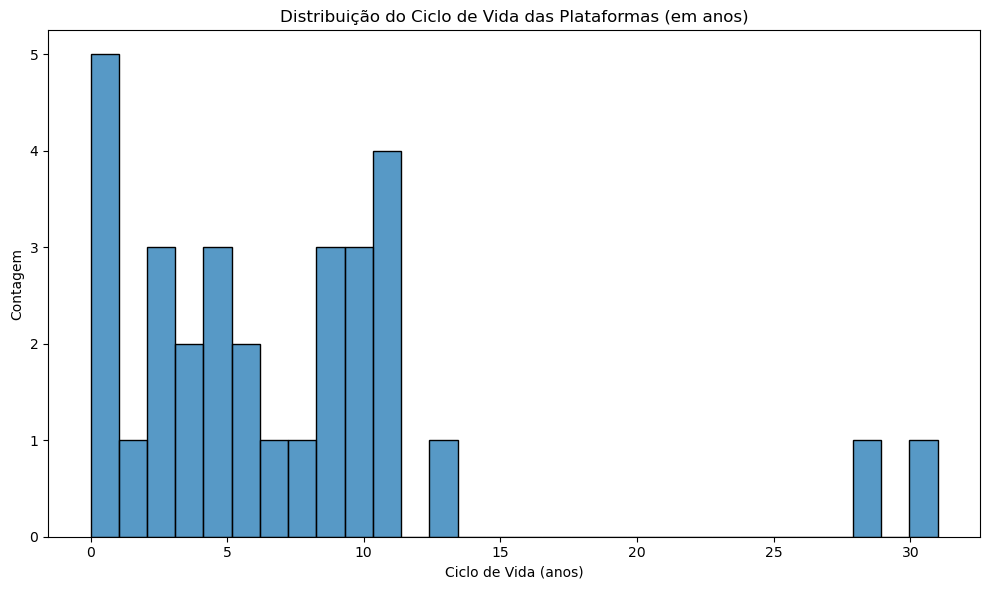

In [21]:
# Plotando a distribuição do ciclo de vida

##Código para a biblioteca Plotly
# fig = px.histogram(
#     platform_life_cycle,
#     x='lifetime_years',
#     title="Distribuição do Ciclo de Vida das Plataformas (em anos)",
#     labels={'lifetime_years': 'Ciclo de Vida (anos)'},
#     nbins=30
# )
# fig.show()

##Código para a biblioteca Seaborn

plt.figure(figsize=(10, 6))
sns.histplot(
    data=platform_life_cycle,
    x='lifetime_years',
    bins=30,
    kde=False
)

plt.title("Distribuição do Ciclo de Vida das Plataformas (em anos)")
plt.xlabel("Ciclo de Vida (anos)")
plt.ylabel("Contagem")
plt.tight_layout()
plt.show()

In [22]:
# Calculando o tempo para atingir o pico de vendas
peak_time = sales_per_plaftorm_per_year.groupby('platform').apply(
    lambda x: x.loc[x['total_sales'].idxmax(), 'year_of_release'] -
    x['year_of_release'].min()
).reset_index(name='years_to_peak')

# Estatísticas do tempo para o pico
peak_stats = peak_time['years_to_peak'].describe()
print("\nEstatísticas do tempo para atingir o pico de vendas:")
print(peak_stats)


Estatísticas do tempo para atingir o pico de vendas:
count    31.000000
mean      3.387097
std       5.719425
min       0.000000
25%       1.000000
50%       2.000000
75%       3.500000
max      26.000000
Name: years_to_peak, dtype: float64


C:\Users\vinic\AppData\Local\Temp\ipykernel_29080\7276611.py:2: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



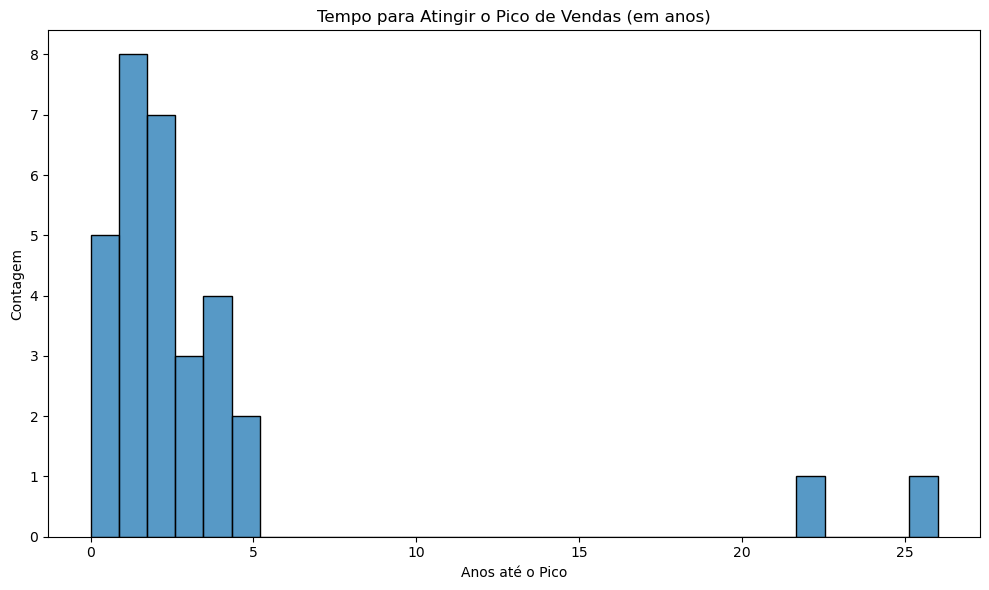

In [23]:
# Plotando a distribuição do tempo para o pico de vendas

##Código para a biblioteca Plotly
# fig = px.histogram(
#     peak_time,
#     x='years_to_peak',
#     title="Tempo para Atingir o Pico de Vendas (em anos)",
#     labels={'years_to_peak': 'Anos até o Pico'},
#     nbins=30
# )
# fig.show()

##Código para a biblioteca seaborn

plt.figure(figsize=(10, 6))
sns.histplot(
    data=peak_time,
    x='years_to_peak',
    bins=30,
    kde=False
)

plt.title("Tempo para Atingir o Pico de Vendas (em anos)")
plt.xlabel("Anos até o Pico")
plt.ylabel("Contagem")
plt.tight_layout()
plt.show()

Observando o gráfico, podemos perceber que:
- O PlayStation 2 foi muito popular e dominante em vendas desde o ano 2000, tendo sempre uma popularidade alta e consistente, porém perdendo espaço a partir de 2006 com o lançamento do Nintendo Wii e do PlayStation 3 e da popularização do Nintendo DS;
- O Nintendo DS, em seu primeiro ano não foi tão popular, porém teve uma explosão de vendas a partir do ano seguinte e mantendo números consistentes até por volta de 2010, quando sua popularidade caiu;
- O Xbox 360 e o PlayStation 3 tiveram comportamento parecidos, aumentando gradualmente a popularidade, e por consequência as vendas, e então perdendo espaço por volta de 2014, muito provavelmente por conta de lançamentos novos de linhas subsequentes das mesmas plataformas;
- Já o Nintendo Wii começou muito forte em popularidade desde o lançamento, porém com queda abrupta de popularidade a partir de 2011;
- Para o caso da PlayStation, é possível perceber que, com o lançamento de uma nova versão da plataforma de jogos, a plataforma antiga perde forças e então a nova se populariza, além de visível dominância no mercado pela marca nos últimos anos;
- Em média, as plataformas tem um ciclo de vida em torno de 7 anos, com alguns raros casos ultrapassando valores acima dos 20 anos;
- Em média, as plataformas atingem o pico de vendas por volta de três anos desde o seu lançamento;

Considerando as informações acima, vamos trabalhar e observar os últimos 5 anos para basear nossa análise.

C:\Users\vinic\AppData\Local\Temp\ipykernel_29080\139493343.py:26: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




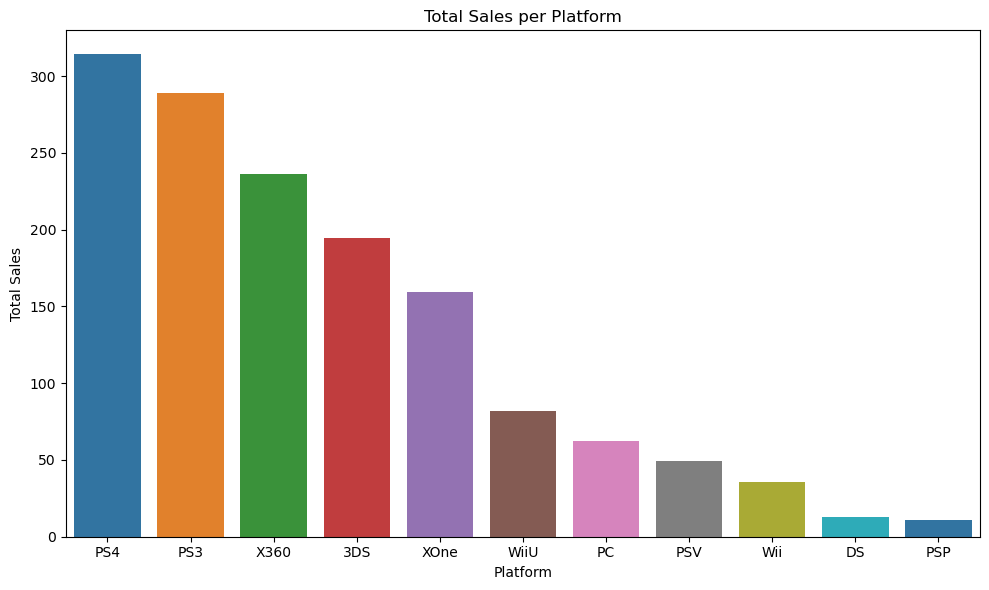

In [25]:
# Visualizando quais plataformas tiveram mais vendas no últimos 5 anos

sales_last_5_years = games[games['year_of_release'] >= 2012]
total_sales = sales_last_5_years.groupby(
    'platform')['total_sales'].sum().reset_index()
total_sales = total_sales.sort_values(
    by='total_sales', ascending=False).reset_index(drop=True)
total_sales

##Código utilizando a biblioteca Plotly
# fig = px.bar(total_sales,
#              x='platform',
#              y='total_sales',
#              labels={
#                  'platform': 'Platform',
#                  'total_sales': 'Total Sales'
#              },
#              title='Total Sales per Platform',
#              color='platform')

# fig.show()

##Código utilizando a biblioteca Seaborn

plt.figure(figsize=(10, 6))
sns.barplot(
    data=total_sales,
    x='platform',
    y='total_sales',
    palette='tab10'  # cores diferentes por plataforma, similar ao plotly
)

plt.title('Total Sales per Platform')
plt.xlabel('Platform')
plt.ylabel('Total Sales')
plt.tight_layout()
plt.show()

A PlayStation lidera bem forte o mercado nos últimos anos, principalmente com a transição de popularaização entre o PS3, que continua muito popular, e o PS4, que tem uma alta quantidade de vendas no período. As plataformas Xbox vêm logo atrás, como o Xbox 360 ainda popular e o Xbox One tendo mais dificuldade que o PS4 para se popularizar.

Porém, para entender realmente como anda a popularização de uma plataforma nos últimos anos, nada melhor do que visualizar esse comportamento no decorrer dos anos, a fim de entender as tendências.

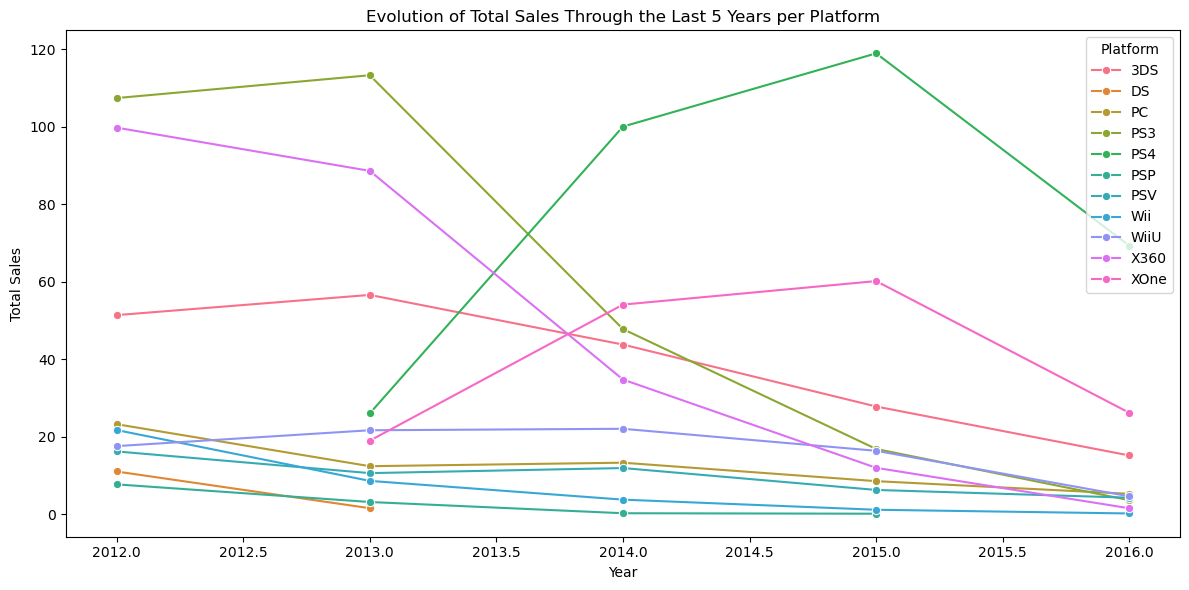

In [26]:
# Visualização da evolução de vendas no decorrer dos anos

## Código utilizando a biblioteca Plotly
# fig = px.line(sales_last_5_years.groupby(['platform', 'year_of_release'])['total_sales'].sum().reset_index(),
#               x='year_of_release',
#               y='total_sales',
#               labels={
#                   'year_of_release': 'Year',
#                   'total_sales': 'Total Sales'
# },
#     title='Evolution of Total Sales Through the Last 5 Years per Platform',
#     color='platform'
# )

# fig.show()

## Código utilizando a biblioteca Seaborn

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=sales_last_5_years.groupby(['platform', 'year_of_release'])['total_sales'].sum().reset_index(),
    x='year_of_release',
    y='total_sales',
    hue='platform',
    marker='o'
)

plt.title('Evolution of Total Sales Through the Last 5 Years per Platform')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.legend(title='Platform')
plt.tight_layout()
plt.show()

Como era de se esperar: com o lançamento de uma nova versão de uma plataforma, a popularização da anterior cai, sendo então substituída, podemos ver isso principalmente na transição PS3 -> PS4 e Xbox 360 -> Xbox One, porém o PS4 domina as vendas de jogos, se mantendo sempre à frente desde o lançamento. Ambas as plataformas se tornaram mais populares do que suas antigas versões muito rápido, em questão de 1 ano.
As duas plataformas também são as únicas que apresentaram uma tendência de aumento de popularidade nos últimos anos, enquanto as outras plataformas apenas perdem espaço, porém algo em comum entre todas: no último ano, em 2016, todas as plataformas caíram em vendas.

In [74]:
# Visualização da distribuição de vendas por plataforma no últimos anos

fig = px.box(sales_last_5_years,
             x='platform',
             y='total_sales',
             title='Sales Distribution per Platform',
             labels={
                 'platform': 'Platform',
                 'total_sales': 'Total Sales'
             })

fig.show()

In [75]:
# Visualização das médias de vendas

mean_sales = sales_last_5_years.groupby(
    'platform')['total_sales'].mean().reset_index()
fig = px.bar(mean_sales,
             x='platform',
             y='total_sales',
             title='Mean Sales per Platform',
             labels={
                 'platform': 'Platform',
                 'total_sales': 'Total Sales'
             })

fig.show()

In [76]:
# Visualização das medianas de vendas

median_sales = sales_last_5_years.groupby(
    'platform')['total_sales'].median().reset_index()
fig = px.bar(median_sales,
             x='platform',
             y='total_sales',
             title='Median Sales per Platform',
             labels={
                 'platform': 'Platform',
                 'total_sales': 'Total Sales'
             })

fig.show()

Dos gráficos acima,  a princípio não é possível perceber que existe uma discrepância no comportamento de vendas entre as plataformas por conta dos outliers, porém, ao olharmos para as médias e medianas, podemos pereber que as plataformas PlayStation, Xbox possuem valores mais altos de vendas de jogos no período, acompanhados do Nintendo Wii.

Para uma plataforma ter boas vendas, não basta ela em si ser boa, sem bons jogos, não se tem popularidade, portanto é muito importante entender como as críticas, tanto de usuários, como de críticos afetam as vendas de jogos. vamo tomar como exemplo a plataforma PS4, a mais popular do último ano para entender como as vendas se comportam de acordo com as críticas.

In [77]:
# Visualização da relação entre total de vendas e pontuação dos críticos para o PS4

ps4_sales = games[games['platform'] == 'PS4']

fig = px.scatter(ps4_sales[ps4_sales['critic_score'] > 0],
                 x='critic_score',
                 y='total_sales',
                 title='Relationship Between Sales and Critic Score',
                 labels={
    'total_sales': 'Total Sales',
    'critic_score': 'Critic Score'
})

fig.show()
print('Correlação entre total_sales e critic_score:',
      ps4_sales[ps4_sales['critic_score'] > 0]['critic_score'].corr(ps4_sales['total_sales']))

Correlação entre total_sales e critic_score: 0.4065679020617816


In [78]:
# Visualização da relação entre total de vendas e pontuação dos usuários para o PS4

fig = px.scatter(ps4_sales[ps4_sales['user_score'] > 0],
                 x='user_score',
                 y='total_sales',
                 title='Relationship Between Sales and Critic Score',
                 labels={
    'total_sales': 'Total Sales',
    'user_score': 'User Score'
})

fig.show()

filtro = ps4_sales['user_score'] > 0
print('Correlação entre total_sales e user_score:',
      ps4_sales.loc[filtro, 'user_score'].corr(ps4_sales.loc[filtro, 'total_sales']))

Correlação entre total_sales e user_score: -0.03195711020455644


Dos gráficos e dos números acima, é possível perceber que para ambos os casos, mas mais especialmente para a relação envolvendo a pontuação dos usuários, a correlação com o total de vendas é fraca, porém, a opinião dos críticos importa mais, não só pelo maior valor de correlação, mas também por ter uma correlação positiva, o que não acontece em relação à opinião dos usuários.

Para entender a popularidade e como as vendas são afetadas, também é necessário entender como se comporta as vendas dos jogos, seja em cada plataforma ou não, portanto, hora de analisar os dados sobre as vendas de cada jogo.

In [79]:
# Visualização dos 15 jogos com mais vendas no últimos 5 anos

top_15_games = sales_last_5_years.nlargest(15, 'total_sales')['name'].unique()

fig = px.bar(sales_last_5_years[sales_last_5_years['name'].isin(top_15_games)],
             x='name',
             y='total_sales',
             color='platform',
             labels={
    'total_sales': 'Total Sales',
    'platform': 'Platform'
})

fig.show()

Do gráfico acima, é possível perceber que, no geral, os jogos mais vendidos são jogos disponíveis em mais de uma plataforma, o que faz muito sentido, pois se é um jogo popular e que está disponível para ser jogado em mais de uma plataforma, isso é mais conveniente para os usuários e atrai mais a preferência do que jogos que estão disponíveis somente em uma plataforma.

In [80]:
# Visualização da quantidade de vendas por genêro

sales_by_gender = sales_last_5_years.groupby(
    'genre')['total_sales'].sum().reset_index()
sales_by_gender = sales_by_gender.sort_values(
    by='total_sales', ascending=False).reset_index(drop=True)

fig = px.bar(sales_by_gender,
             x='genre',
             y='total_sales',
             title='Total Sales by Genre',
             labels={
                 'total_sales': 'Total Sales',
                 'genre': 'Genre'
             })

fig.show()

É possível perceber que os jogos mais vendidos envolvem ação de alguma forma, visto pelo próprio gênero Ação e o gênero Tiro, além do Role-Playing que também envolve um pouco de ação.

In [81]:
# Visualizando distribuição de vendas para cada gênero

fig = px.box(sales_last_5_years,
             x='genre',
             y='total_sales',
             title='Distribution of Sales per Genre',
             labels={
                 'total_sales': 'Total Sales',
                 'genre': 'Genre'
             })

fig.show()

Existem muitos outliers nas vendas para cada gênero, porém é possível perceber que no geral o gênero Shooter tem um alcance maior de total de vendas, sendo ultrapassado somente por Action e Role-Playing, além de um caso isolado de Misc. Vamos observar os valores da média e mediana separados para ter uma noção melhor.

In [82]:
# Visualização da média de vendas por gênero
mean_sales_by_gender = sales_last_5_years.groupby(
    'genre')['total_sales'].mean().reset_index()

fig = px.bar(mean_sales_by_gender,
             x='genre',
             y='total_sales',
             labels={
                 'genre': 'Genre',
                 'total_sales': 'Total Sales'
             },
             title='Mean Sales per Genre')

fig.show()

In [83]:
# Visualização da mediana de vendas por gênero
median_sales_by_gender = sales_last_5_years.groupby(
    'genre')['total_sales'].median().reset_index()

fig = px.bar(median_sales_by_gender,
             x='genre',
             y='total_sales',
             labels={
                 'genre': 'Genre',
                 'total_sales': 'Total Sales'
             },
             title='Median Sales per Genre')

fig.show()

Observando os dois gráficos, é possível perceber que os jogos do gênero Shooter, Platform e Sports tem as maiores médias e medianas de vendas dentre todos os gêneros de jogos, porém os jogos do gênero Shooter apresentam uma discrepância muito maior em relação aos outros.

Apesar de o total de vendas para jogo de Ação serem maiores, eles são liderados por alguns jogos outliers que têm vendas muito altas, enquanto os jogos do gênero Shooter apresenta uma maior consistência no valores de venda por jogo, e com valores altos, levando a estar como segundo gênero mais vendido.

Observando também é possível concluir que jogos que se assemelham um pouco mais com o gênero Ação tem os maiores números de vendas, sendo mais populares pelo público.

Essas são as conclusões para os números em geral, porém podemos ver que os dados de venda também possuem informações sobre vendas em diferentes partes do mundo, o que levanta algumas questões: 
- Como será que é o comportamento de vendas de jogos de acordo com cada região do globo? 
- Será que os mesmos comportamentos em relação a plataformas se aplica a cada região?
- Será que os usuários têm os mesmos gostos em relação a gênero a depender da região?

In [84]:
# Gerando informações de vendas por plataforma na Europa

eu_sales_per_platform = sales_last_5_years.groupby(
    'platform')['eu_sales'].sum().reset_index()
eu_sales_per_platform = eu_sales_per_platform.sort_values(
    by='eu_sales', ascending=False).reset_index(drop=True)
eu_sales_per_platform.rename(
    columns={'eu_sales': 'eu_total_sales'}, inplace=True)
eu_sales_per_platform

,platform,eu_total_sales
0,PS4,141.09
1,PS3,106.86
2,X360,74.52
3,XOne,51.59
4,3DS,42.64
5,PC,37.76
6,WiiU,25.13
7,Wii,11.92
8,PSV,11.36
9,DS,3.53


In [85]:
# Gerando informações de vendas por plataforma na América do Norte

na_sales_per_platform = sales_last_5_years.groupby(
    'platform')['na_sales'].sum().reset_index()
na_sales_per_platform = na_sales_per_platform.sort_values(
    by='na_sales', ascending=False).reset_index(drop=True)
na_sales_per_platform.rename(
    columns={'na_sales': 'na_total_sales'}, inplace=True)
na_sales_per_platform

,platform,na_total_sales
0,X360,140.05
1,PS4,108.74
2,PS3,103.38
3,XOne,93.12
4,3DS,55.31
5,WiiU,38.10
6,PC,19.12
7,Wii,17.45
8,PSV,10.98
9,DS,4.59


In [86]:
# Gerando informações de vendas por plataforma no Japão

jp_sales_per_platform = sales_last_5_years.groupby(
    'platform')['jp_sales'].sum().reset_index()
jp_sales_per_platform = jp_sales_per_platform.sort_values(
    by='jp_sales', ascending=False).reset_index(drop=True)
jp_sales_per_platform.rename(
    columns={'jp_sales': 'jp_total_sales'}, inplace=True)
jp_sales_per_platform

,platform,jp_total_sales
0,3DS,87.79
1,PS3,35.29
2,PSV,21.04
3,PS4,15.96
4,WiiU,13.01
5,PSP,10.47
6,DS,3.72
7,Wii,3.39
8,X360,1.57
9,XOne,0.34


In [87]:
# Gerando informações de vendas por plataforma em outras regiões

other_sales_per_platform = sales_last_5_years.groupby(
    'platform')['other_sales'].sum().reset_index()
other_sales_per_platform = other_sales_per_platform.sort_values(
    by='other_sales', ascending=False).reset_index(drop=True)
other_sales_per_platform.rename(
    columns={'other_sales': 'other_total_sales'}, inplace=True)
other_sales_per_platform

,platform,other_total_sales
0,PS4,48.35
1,PS3,43.26
2,X360,20.40
3,XOne,14.27
4,3DS,8.87
5,WiiU,5.95
6,PSV,5.80
7,PC,5.77
8,Wii,2.61
9,DS,0.71


Olhando só para as tabelas, parece que o Japão tem uma prerência diferente por plataformas do que as outras regiões, porém observando só os números não nos dá essa clareza, então vamos colocar num gráfico para confirmar nossa suspeita.

In [88]:
# Juntando as informações de vendas das top 5 plataformas de cada região

eu_top_5 = eu_sales_per_platform.nlargest(5, 'eu_total_sales')
na_top_5 = na_sales_per_platform.nlargest(5, 'na_total_sales')
jp_top_5 = jp_sales_per_platform.nlargest(5, 'jp_total_sales')
other_top_5 = other_sales_per_platform.nlargest(5, 'other_total_sales')

regions_top_5_per_platform = eu_top_5.merge(na_top_5,
                                            on='platform',
                                            how='outer').merge(jp_top_5,
                                                               on='platform',
                                                               how='outer').merge(other_top_5,
                                                                                  on='platform',
                                                                                  how='outer')
regions_top_5_per_platform

,platform,eu_total_sales,na_total_sales,jp_total_sales,other_total_sales
0,3DS,42.64,55.31,87.79,8.87
1,PS3,106.86,103.38,35.29,43.26
2,PS4,141.09,108.74,15.96,48.35
3,PSV,NaN,NaN,21.04,NaN
4,WiiU,NaN,NaN,13.01,NaN
5,X360,74.52,140.05,NaN,20.40
6,XOne,51.59,93.12,NaN,14.27


In [89]:
# Visulizando a tabela em um gráfico de barras

# Converte o DataFrame para formato longo para facilitar a plotagem
df_long_platform = regions_top_5_per_platform.melt(
    id_vars="platform", var_name="region", value_name="sales")

# Mapeia os nomes das regiões
region_labels = {
    "eu_total_sales": "EU Total Sales",
    "na_total_sales": "NA Total Sales",
    "jp_total_sales": "Japan Total Sales",
    "other_total_sales": "Other Regions Total Sales"
}

# Cria o gráfico de barras agrupado
fig = px.bar(df_long_platform, x="platform", y="sales", color="region",
             title="Total Sales per Platform and Region",
             labels={
                 "sales": "Total Sales (Millions)",
                 "platform": "Plataform",
                 "region": "Region"
             },
             barmode="group")

# Atualiza os nomes das regiões na legenda
fig.for_each_trace(lambda t: t.update(name=region_labels[t.name]))

# Exibe o gráfico
fig.show()

Podemos ver claramente que o Japão tem uma preferência muito diferente por plataformas em comparação com o resto do mundo, o que com certeza nos leva a, ao construir um plano de ação para vendas de jogos, no caso do Japão, ele deve ser personalizado.

In [90]:
# Gerando informações de vendas por gênero na Europa

eu_sales_per_genre = sales_last_5_years.groupby(
    'genre')['eu_sales'].sum().reset_index()
eu_sales_per_genre = eu_sales_per_genre.sort_values(
    by='eu_sales', ascending=False).reset_index(drop=True)
eu_sales_per_genre.rename(columns={'eu_sales': 'eu_total_sales'}, inplace=True)

# Gerando informações de vendas por gênero na América do Norte

na_sales_per_genre = sales_last_5_years.groupby(
    'genre')['na_sales'].sum().reset_index()
na_sales_per_genre = na_sales_per_genre.sort_values(
    by='na_sales', ascending=False).reset_index(drop=True)
na_sales_per_genre.rename(columns={'na_sales': 'na_total_sales'}, inplace=True)

# Gerando informações de vendas por gênero no Japão

jp_sales_per_genre = sales_last_5_years.groupby(
    'genre')['jp_sales'].sum().reset_index()
jp_sales_per_genre = jp_sales_per_genre.sort_values(
    by='jp_sales', ascending=False).reset_index(drop=True)
jp_sales_per_genre.rename(columns={'jp_sales': 'jp_total_sales'}, inplace=True)

# Gerando informações de vendas por gênero em outras regiões

other_sales_per_genre = sales_last_5_years.groupby(
    'genre')['other_sales'].sum().reset_index()
other_sales_per_genre = other_sales_per_genre.sort_values(
    by='other_sales', ascending=False).reset_index(drop=True)
other_sales_per_genre.rename(
    columns={'other_sales': 'other_total_sales'}, inplace=True)

# Juntando as informações de vendas de cada gênero por região região

regions_per_genre = eu_sales_per_genre.merge(na_sales_per_genre,
                                             on='genre',
                                             how='outer').merge(jp_sales_per_genre,
                                                                on='genre',
                                                                how='outer').merge(other_sales_per_genre,
                                                                                   on='genre',
                                                                                   how='outer')
regions_per_genre

,genre,eu_total_sales,na_total_sales,jp_total_sales,other_total_sales
0,Action,159.34,177.84,52.80,51.14
1,Adventure,9.46,8.92,8.24,2.81
2,Fighting,10.79,19.79,9.44,4.47
3,Misc,26.32,38.19,12.86,7.67
4,Platform,21.41,25.38,8.63,5.58
5,Puzzle,1.40,1.13,2.14,0.22
6,Racing,27.29,17.22,2.50,6.49
7,Role-Playing,48.53,64.00,65.44,14.83
8,Shooter,113.47,144.77,9.23,37.26
9,Simulation,14.55,7.97,10.41,2.19


In [91]:
# Visulizando a tabela em um gráfico de barras

# Converte o DataFrame para formato longo para facilitar a plotagem
df_long_genre = regions_per_genre.melt(
    id_vars="genre", var_name="region", value_name="sales")

# Mapeia os nomes das regiões
region_labels = {
    "eu_total_sales": "EU Total Sales",
    "na_total_sales": "NA Total Sales",
    "jp_total_sales": "Japan Total Sales",
    "other_total_sales": "Other Regions Total Sales"
}

# Cria o gráfico de barras agrupado
fig = px.bar(df_long_genre, x="genre", y="sales", color="region",
             title="Total Sales per Platform and Region",
             labels={
                 "sales": "Total Sales (Millions)",
                 "genre": "Genre",
                 "region": "Region"
             },
             barmode="group")

# Atualiza os nomes das regiões na legenda
fig.for_each_trace(lambda t: t.update(name=region_labels[t.name]))

# Exibe o gráfico
fig.show()

Pra confirmar ainda mais que o Japão tem um gosto diferente quando se trata de jogos, as preferências em relação ao tipo de jogo também são diferentes por lá, preferindo mais jogos estilo RPG do que jogos de Ação e Shooter, que são as prerências em outras regiões do mundo.

Uma outra questão pode ser levantada: será que a classificação indicativa dos jogos influenciam as vendas a depender da região?

In [92]:
# # Gerando informações de vendas por gênero na Europa

eu_sales_per_rating = sales_last_5_years.groupby(
    'rating')['eu_sales'].sum().reset_index()
eu_sales_per_rating = eu_sales_per_rating.sort_values(
    by='eu_sales', ascending=False).reset_index(drop=True)
eu_sales_per_rating.rename(
    columns={'eu_sales': 'eu_total_sales'}, inplace=True)

# Gerando informações de vendas por gênero na América do Norte

na_sales_per_rating = sales_last_5_years.groupby(
    'rating')['na_sales'].sum().reset_index()
na_sales_per_rating = na_sales_per_rating.sort_values(
    by='na_sales', ascending=False).reset_index(drop=True)
na_sales_per_rating.rename(
    columns={'na_sales': 'na_total_sales'}, inplace=True)

# Gerando informações de vendas por gênero no Japão

jp_sales_per_rating = sales_last_5_years.groupby(
    'rating')['jp_sales'].sum().reset_index()
jp_sales_per_rating = jp_sales_per_rating.sort_values(
    by='jp_sales', ascending=False).reset_index(drop=True)
jp_sales_per_rating.rename(
    columns={'jp_sales': 'jp_total_sales'}, inplace=True)

# Gerando informações de vendas por gênero em outras regiões

other_sales_per_rating = sales_last_5_years.groupby(
    'rating')['other_sales'].sum().reset_index()
other_sales_per_rating = other_sales_per_rating.sort_values(
    by='other_sales', ascending=False).reset_index(drop=True)
other_sales_per_rating.rename(
    columns={'other_sales': 'other_total_sales'}, inplace=True)

# Juntando as informações de vendas de cada gênero por região região

regions_per_rating = eu_sales_per_rating.merge(na_sales_per_rating,
                                               on='rating',
                                               how='outer').merge(jp_sales_per_rating,
                                                                  on='rating',
                                                                  how='outer').merge(other_sales_per_rating,
                                                                                     on='rating',
                                                                                     how='outer')
regions_per_rating

,rating,eu_total_sales,na_total_sales,jp_total_sales,other_total_sales
0,E,113.03,114.37,28.33,31.44
1,E10+,55.37,75.70,8.19,16.23
2,M,193.96,231.57,21.20,63.38
3,NR,91.50,103.31,108.84,27.17
4,T,52.96,66.02,26.02,17.94


In [93]:
# Visulizando a tabela em um gráfico de barras

# Converte o DataFrame para formato longo para facilitar a plotagem
df_long_rating = regions_per_rating.melt(
    id_vars="rating", var_name="region", value_name="sales")

# Mapeia os nomes das regiões
region_labels = {
    "eu_total_sales": "EU Total Sales",
    "na_total_sales": "NA Total Sales",
    "jp_total_sales": "Japan Total Sales",
    "other_total_sales": "Other Regions Total Sales"
}

# Cria o gráfico de barras agrupado
fig = px.bar(df_long_rating, x="rating", y="sales", color="region",
             title="Total Sales per Platform and Region",
             labels={
                 "sales": "Total Sales (Millions)",
                 "rating": "Rating",
                 "region": "Region"
             },
             barmode="group")

# Atualiza os nomes das regiões na legenda
fig.for_each_trace(lambda t: t.update(name=region_labels[t.name]))

# Exibe o gráfico
fig.show()

Podemos perceber algo interessante: no Japão, a maioria das vendas são de jogos sem classificação alguma, porém, excluindo esses jogos, o comportamente de vendas é muito parecido, com o Japão mais uma vez não seguindo a tendência: enquanto nas outras regiões do mundo, os jogos para público adulto lidera o ranking, sendo seguido por jogos para todos os públicos e jogos para jovens, no japão os jogos para público não são tão preferidos, com os jogadores preferindo jogos para qualquer público ou público jovem.

## Testando hipóteses

Chegou a hora de testar algumas hipóteses sobre nossos dados. Vamos pensar em algumas:
- Olhando para as plataformas Xbox One e PC, será que a classificação média dos usuários é a mesma nas duas plataformas?
- Para os jogos de Ação e Sports, será que existe diferença na classificação média dos usuários?

Para os testes de hipótese será utilizado o limiar padrão de 95%, que é o mais utilizado quando se trata de testes de hipótese.

### Teste da igualdade de médias de classificação de usuário para Xbox One e PC

**Hipótese nula(H0):** As médias são iguais

**Hipótese alternativa(H1):** As médias são diferentes

In [94]:
# Filtrando os dados
xbox_scores = sales_last_5_years[sales_last_5_years['platform'] == 'XOne']
xbox_scores = xbox_scores[xbox_scores['user_score'] > 0]
print('Média de classificação para Xbox One:',
      xbox_scores['user_score'].mean())

pc_scores = sales_last_5_years[sales_last_5_years['platform'] == 'PC']
pc_scores = pc_scores[pc_scores['user_score'] > 0]
print('Média de classificação para PC:', pc_scores['user_score'].mean())

# teste para verificação de igualdade de variâncias
# Hipótese nula(H0): as variâncias são iguais
# Hipótese alternativa(H1): as variâncias são diferentes
stat, p = levene(xbox_scores['user_score'], pc_scores['user_score'])

alpha = 0.05
print(f'Valor-p: {p}')

if p < alpha:
    print("Rejeitamos H0: as variâncias são diferentes")
else:
    print("Não podemos rejeitar H0: as variâncias são iguais")

Média de classificação para Xbox One: 65.21428571428571
Média de classificação para PC: 64.2864077669903
Valor-p: 0.012514842818505541
Rejeitamos H0: as variâncias são diferentes


In [95]:
# Teste t de Student
t_stat, p_value = st.ttest_ind(
    xbox_scores['user_score'], pc_scores['user_score'], equal_var=False)

alpha = 0.05
print(f'Valor-p: {p}')

if p < alpha:
    print("Rejeitamos H0: as médias são diferentes")
else:
    print("Não podemos rejeitar H0: as médias são iguais")

Valor-p: 0.012514842818505541
Rejeitamos H0: as médias são diferentes


Podemos perceber então que a classificação dos usuários para os jogos em ambas as plataformas são em média diferentes.

### Teste da igualdade de médias de classificação de usuário para Action e Sports

**Hipótese nula(H0):** As médias são iguais

**Hipótese alternativa(H1):** As médias são diferentes

In [96]:
# Filtrando os dados
action_scores = sales_last_5_years[sales_last_5_years['genre'] == 'Action']
action_scores = action_scores[action_scores['user_score'] > 0]
print('Média de classificação para jogos de Ação:',
      action_scores['user_score'].mean())

sports_scores = sales_last_5_years[sales_last_5_years['genre'] == 'Sports']
sports_scores = sports_scores[sports_scores['user_score'] > 0]
print('Média de classificação para jogos de Esportes:',
      sports_scores['user_score'].mean())

# teste para verificação de igualdade de variâncias
# Hipótese nula(H0): as variâncias são iguais
# Hipótese alternativa(H1): as variâncias são diferentes
stat, p = levene(action_scores['user_score'], sports_scores['user_score'])

alpha = 0.05
print(f'Valor-p: {p}')

if p < alpha:
    print("Rejeitamos H0: as variâncias são diferentes")
else:
    print("Não podemos rejeitar H0: as variâncias são iguais")

Média de classificação para jogos de Ação: 68.25047801147228
Média de classificação para jogos de Esportes: 54.55897435897436
Valor-p: 1.3125789036876737e-05
Rejeitamos H0: as variâncias são diferentes


In [97]:
# Teste t de Student
t_stat, p_value = st.ttest_ind(
    action_scores['user_score'], sports_scores['user_score'], equal_var=False)

alpha = 0.05
print(f'Valor-p: {p}')

if p < alpha:
    print("Rejeitamos H0: as médias são diferentes")
else:
    print("Não podemos rejeitar H0: as médias são iguais")

Valor-p: 1.3125789036876737e-05
Rejeitamos H0: as médias são diferentes


Assim como no caso anterior, os usuários tendem a classificar os jogos de ação, em média, diferente dos jogos de esporte.

## Conclusão

Depois de todas as análises, foi possível tirar as seguintes conclusões:

- As vendas de jogos vêm crescendo desde a década de 90, alcançando um pico no final da década de 2000, porém com uma queda nos últimos anos;
- As plataformas tendem a começar com pouca popularidade assim que lançadas, porém crescendo com o tempo; outro ponto importante é que, com a chegada de uma nova plataforma, como uma nova versão de uma plataforma antiga, a popularidade da antiga tende a diminuir e da nova tende a crescer;
- Tem tido um domínio no mercado das plataformas Xbox e PlayStation, porém a última domina o mercado com constantes vendas maiores do que a primeira;
- As plataformas Xbox e PlayStation têm dominado o mercado de jogos nos últimos anos, com a PlayStation com valores totais maiores e a Xbox com valores médios maiores, liderados principalmente por alguns outliers;
- As críticas dos usuários e dos críticos têm pouca relação com o valor total de vendas, porém a avaliação dos críticos têm melhor correlação;
- Os jogos mais vendidos não só são jogos de ação ou tiro, mas também são jogos que podem ser jogados em mais de uma plataforma;
- Apesar de os jogos de ação serem os mais vendidos, suas vendas são lideradas por muitos oultiers, observado pela média não tão alta nos valores de venda, o que não acontece com os jogos de tiro, que têm melhor consistência;
- Em relação a vendas por região, o Japão é um mercado bem único, com preferências bem diferentes do resto do mundo, tanto para platafromas, quanto para tipos de jogos e classificação indicativa dos jogos;
- As médias de classificação para Xbox One são estatíticamente maiores do que para PC;
- As médias de classificação para jogos de ação são estatísticamente maiores do que jogos de esporte;